In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter 

import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [3]:
import mitosheet

In [4]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

In [6]:
from solver import deasolver

### Unstructured Variance, n_input = 12, n_output = 1

In [7]:
m = n_input = 12
s = n_output = 1

In [9]:
def generate_dataset(m=12, s=1, std=3, how_many=1, seed=321):
    df_list = []
    
    for ind in range(how_many):
    
        np.random.seed(ind + seed)
        x_min = np.random.randint(1,101, m+s)

        delta_x = np.random.uniform(1,1000, m+s)
        
        x_max = x_min + delta_x
        mean_q = (x_min + x_max)  * 0.5
        std_max = (x_max - x_min) * 0.5 * (1/std)
        
        std_list = []

        for i in std_max:
            std_list.append(np.random.uniform(0,i))
            
        cov_matrix_int = []

        for i in range(m + s):
            for j in range(m + s):

                if j>i:
                    min_ = - std_list[i] *  std_list[j]
                    max_ = std_list[i] *  std_list[j]

                    cov_matrix_int.append((i, j, min_, max_)) 
                    
        cov_list = []

        for i, el in enumerate(cov_matrix_int):
            n = np.random.uniform(el[2],el[3])
            cov_list.append(n)
        
        cov_matrix = np.zeros((m + s, m + s))
        
        k=0
        l=0
        for i in range(len(cov_matrix)):
            for j in range(len(cov_matrix)):
                if j>i:
                    cov_matrix[i][j] = cov_matrix[j][i] = cov_list[k]
                    k += 1
                if i == j:
                    cov_matrix[i][j] = np.square(std_list[l]) 
                    l += 1 

        US = pd.DataFrame(np.random.multivariate_normal(mean_q, cov_matrix, 100))
        US.columns = ["Input " + str(i + 1).zfill(2) for i in range(m)] + ["Output " + str(i + 1).zfill(2) for i in range(s)]
        US.index = ["DMU " + str(i + 1).zfill(4) for i in range(len(US))]
        US = US.round(2)

        zero_count = (US<=0).sum().sum()
        print("zero_count: ", zero_count)
        if zero_count>0:
            generate_dataset(how_many=1, std = std + 0.1)
        df_list.append(US)
    return df_list

In [10]:
def ml(filepath="Data/Data100/Book1.xlsx"):
    
    df = pd.read_excel(filepath, index_col = 0)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1:]
    
    std_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()
    
    gb_model = GradientBoostingRegressor(random_state=42)

    pipe_gb = make_pipeline(std_scaler, gb_model)

    # cross-validate the pipeline
    print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
    print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
    print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())
    
    learning_rate = [1, 0.5, 0.1,  0.01]
    n_estimators = [50, 100, 200, 500, 1000, 2000]
    max_depth = [3, 5, 10, None]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 20, 30]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    subsample = [0.3, 0.5, 0.75, 1.0]
    
    # specify parameter values to search
    params = {}
    params['gradientboostingregressor__learning_rate'] = learning_rate
    params['gradientboostingregressor__n_estimators'] = n_estimators
    params['gradientboostingregressor__max_depth'] = max_depth
    params['gradientboostingregressor__min_samples_split'] = min_samples_split
    params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
    params['gradientboostingregressor__subsample'] = subsample
    
    grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
    grid.fit(X, y.values.ravel())
    
    print("grid.best_score: ", grid.best_score_)
    print("grid.best_params: ", grid.best_params_)
    print("grid.best_estimator: ", grid.best_estimator_)
    print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())
    
    imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
    df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
    input_imp = list(df_gb.loc[df_gb["Feature Name"].str.contains("Input"), "Feature Name"].values)
    results = (
                grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_,
               },
              )
    
    fig = px.bar(df_gb, x="Importance", y="Feature Name")

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"GradientBoostingRegressor Feature Importances",
        yaxis={'categoryorder':'total ascending'}
    )

    fig.show()
    
 
    return pipe_gb, results, y

neg_mean_squared_error: -1898.2062116193763
neg_root_mean_squared_error: -42.990789044865814
r2: 0.36732553115383026
grid.best_score:  -41.251576775406996
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 50, 'gradientboostingregressor__min_samples_split': 5, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=5,
                                           n_estimators=50, random_state=42,
                                           subsample=0.3))])
grid.r2:  0.39704691770589784


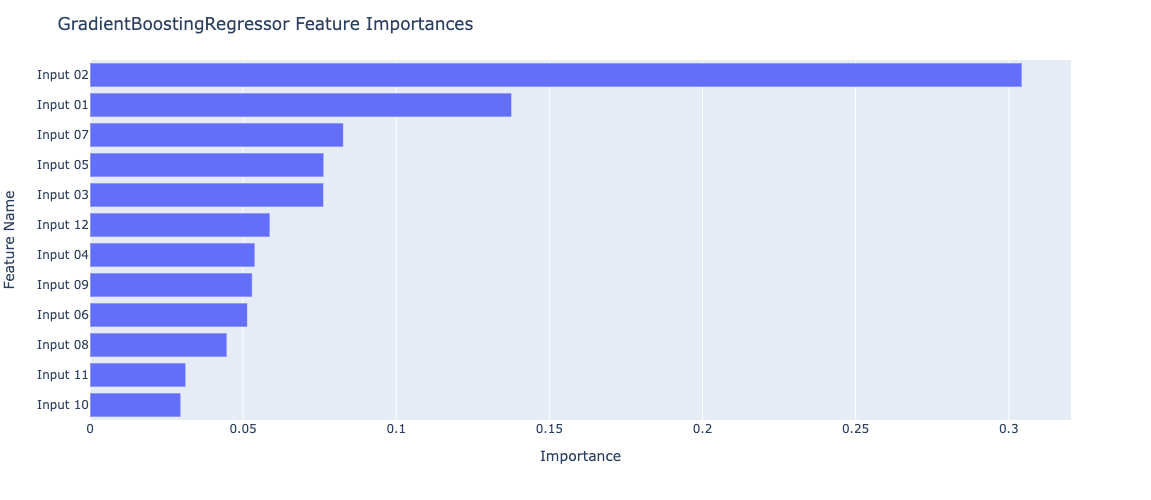

(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingregressor',
                  GradientBoostingRegressor(random_state=42))]),
 ('gradientboostingregressor',
  ['Input 02',
   'Input 01',
   'Input 07',
   'Input 05',
   'Input 03',
   'Input 12',
   'Input 04',
   'Input 09',
   'Input 06',
   'Input 08',
   'Input 11',
   'Input 10'],
  {'r2': 0.39704691770589784,
   'neg_root_mean_squared_error': -41.251576775406996}),
           Output 01
 DMU 0001     162.48
 DMU 0002     190.39
 DMU 0003     225.57
 DMU 0004      92.39
 DMU 0005     179.03
 ...             ...
 DMU 0096     177.85
 DMU 0097     256.82
 DMU 0098     150.98
 DMU 0099     157.40
 DMU 0100     234.72
 
 [100 rows x 1 columns])

In [33]:
ml()

In [10]:
q = generate_dataset(m=12, s=1, std=3, how_many=5)

zero_count:  0
zero_count:  0
zero_count:  0
zero_count:  0
zero_count:  0


/var/folders/6l/c4m0953s1_jgnd_y35l2l7kc0000gp/T/ipykernel_8329/3260715739.py:50: RuntimeWarning:

covariance is not positive-semidefinite.



In [11]:
writer = pd.ExcelWriter("Data/Data100/Book1.xlsx", engine='xlsxwriter')

In [12]:
for ind, el in enumerate(q):
    el.to_excel(writer, sheet_name = str(ind+1))
writer.save()

In [13]:
writer = pd.ExcelWriter("Data/Data100/Book1_Sol.xlsx", engine='xlsxwriter')

for s in range(1,6):
    deasolver(inputfile="Data/Data100/Book1.xlsx", sheetname=str(s), writer = writer, folder = "Data/Data100/", out_suffix1="_Sol_")
writer.save()

Restricted license - for non-production use only - expires 2023-10-25


Restricted license - for non-production use only - expires 2023-10-25


20.0
40.0
60.0
80.0
100.0
Solution file saved
20.0
40.0
60.0
80.0
100.0
Solution file saved
20.0
40.0
60.0
80.0
100.0
Solution file saved
20.0
40.0
60.0
80.0
100.0
Solution file saved
20.0
40.0
60.0
80.0
100.0
Solution file saved
